# Sparkify Churn Prediction Project

### Introduction:

- **This project analyzes user behavior data from the Sparkify music streaming app to predict customer churn.**
- **Churn is defined as users who submitted a 'Cancellation Confirmation'. The analysis includes:**
1. Environment Setup
2. Data cleaning and preprocessing
3. Exploratory Data Analysis (EDA)
5. Feature engineering
5. Machine learning model development and evaluation
- **This project uses a small subset (128MB) of the full dataset (12GB).**

### Important Data Description

- **ts**: timestamp, when this event was recorded in milliseconds
- **userId**: identifier unique for each user
- **firstname**: firstname of user
- **lastname**: lastname of user
- **location**: city
- **gender**: “F” for female, “M” for male
- **registration**: timestamp of subscription
- **level**: “free” or “paid”
- **page**: Webpage visited, or button clicked
- **method**: HTTP Method “GET” or “POST”
- **status**: HTTP Response Code “200”, “307”, “404”
- **userAgent**: browser and operating system used
- **sessionId**: session events
- **auth**: current status of authentication “Logged In”, “Logged Out“
- **song**: title of song
- **length**: length of song in seconds
- **artist**: artist performing the song

## 1- Environment Setup

In [1]:
# import libraries
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, functions
from IPython.display import display# Required to create and manage Spark sessions
# Import general-purpose libraries
import datetime  # For date and time manipulation
import time  # For time-related operations
import re  # For regular expressions
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# Set Java home and update PATH

os.environ['JAVA_HOME'] = '/workspace/jdk'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

# Create Spark session
spark = SparkSession.builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Test Spark session
print("Spark session created successfully!")
print(f"Spark version: {spark.version}")

/opt/venv/lib/python3.10/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/22 20:35:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session created successfully!
Spark version: 3.5.0


## 2- Data Loading & Cleaning

In [3]:
# load in the dataset (128MB subset)
df = spark.read.option("header","True").json("mini_sparkify_event_data.json")
print(df)

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]


In [4]:
# Check data length

df.count()

286500

In [5]:
# Check data Schema

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



- **Handling nulls and missing values**

In [6]:
# Count rows with any null values

rows_with_nulls = df.count() - df.na.drop().count()
print(f"Number of rows with null values: {rows_with_nulls}")

Number of rows with null values: 58392


In [7]:
# Count null values in each column

null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
# check missing values percent (rounded to 2 decimal)

df.select([round(100*sum(col(c).isNull().cast("int")/df.count()), 2).alias(c) for c in df.columns]).collect()

[Row(artist=20.38, auth=0.0, firstName=2.91, gender=2.91, itemInSession=0.0, lastName=2.91, length=20.38, level=0.0, location=2.91, method=0.0, page=0.0, registration=2.91, sessionId=0.0, song=20.38, status=0.0, ts=0.0, userAgent=2.91, userId=0.0)]

- **Notice that no null values exceeded 50% of the total data per column**

In [9]:
# Drop rows with any empty values in userId

df_cleaned=df.filter(df["userId"]!="")
df_cleaned.count()
df_cleaned.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

- **Handling missing and null values based on the column imortance and its function as shown the userID column droped the empty rows as it will be consider as golden key that will be used later on in our anlysise so it can not be imputed with any values**

In [10]:
# Count total rows in the cleaned DataFrame
total_rows = df_cleaned.count()

# Count distinct rows in the cleaned DataFrame
distinct_rows = df_cleaned.distinct().count()

# Calculate the difference (number of duplicate rows)
duplicate_rows = total_rows - distinct_rows

# Print the results
print(f"Total rows in df_cleaned: {total_rows}")
print(f"Distinct rows in df_cleaned: {distinct_rows}")
print(f"Number of duplicate rows in df_cleaned: {duplicate_rows}")

Total rows in df_cleaned: 278154
Distinct rows in df_cleaned: 278154
Number of duplicate rows in df_cleaned: 0


#### No duplicate found in our main data

In [11]:
# Convert registration and ts columns from Unix timestamps (in milliseconds) to TIMESTAMP
df_cleaned = df_cleaned.withColumn("registration_timestamp", from_unixtime(col("registration") / 1000).cast("timestamp")) \
                       .withColumn("ts_timestamp", from_unixtime(col("ts") / 1000).cast("timestamp"))

# Calculate the difference in days
df_cleaned = df_cleaned.withColumn("registration_ts_diff_days", datediff(col("ts_timestamp"), col("registration_timestamp")))


# Show the updated DataFrame
df_cleaned.select("registration", "ts", "registration_timestamp", "ts_timestamp", "registration_ts_diff_days").show(10)

+-------------+-------------+----------------------+-------------------+-------------------------+
| registration|           ts|registration_timestamp|       ts_timestamp|registration_ts_diff_days|
+-------------+-------------+----------------------+-------------------+-------------------------+
|1538173362000|1538352117000|   2018-09-28 22:22:42|2018-10-01 00:01:57|                        3|
|1538331630000|1538352180000|   2018-09-30 18:20:30|2018-10-01 00:03:00|                        1|
|1538173362000|1538352394000|   2018-09-28 22:22:42|2018-10-01 00:06:34|                        3|
|1538331630000|1538352416000|   2018-09-30 18:20:30|2018-10-01 00:06:56|                        1|
|1538173362000|1538352676000|   2018-09-28 22:22:42|2018-10-01 00:11:16|                        3|
|1538331630000|1538352678000|   2018-09-30 18:20:30|2018-10-01 00:11:18|                        1|
|1538331630000|1538352886000|   2018-09-30 18:20:30|2018-10-01 00:14:46|                        1|
|153817336

## 3- Exploratory Data Analysis (EDA)
Performing EDA by loading a small subset of the data and doing basic manipulations within Spark

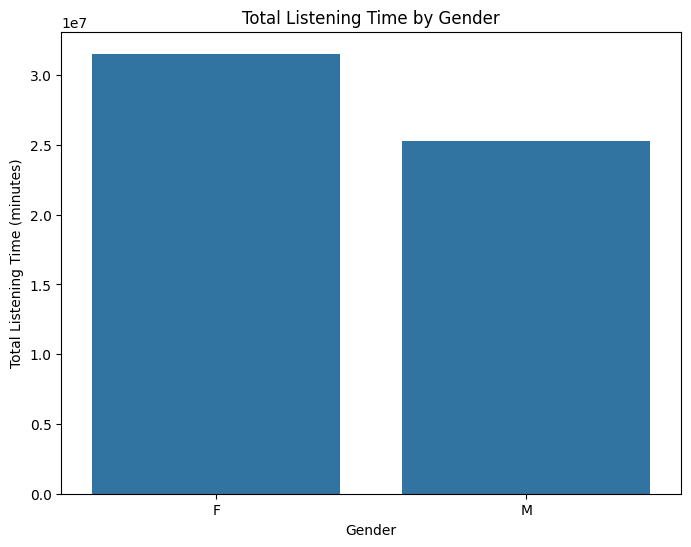

In [12]:
# -------------------------------------------
# Listening Distribution by Gender
# -------------------------------------------

gender_listening = df_cleaned.groupBy("gender").agg(sum("length").alias("total_listening_time")).toPandas()
plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='total_listening_time', data=gender_listening)
plt.title('Total Listening Time by Gender')
plt.ylabel('Total Listening Time (minutes)')
plt.xlabel('Gender')
plt.show()

In our dataset, as shown in the above chart, we can see an increase in female listeners compared to male listeners. We may want to consider expanding the music library to include more male preferences.

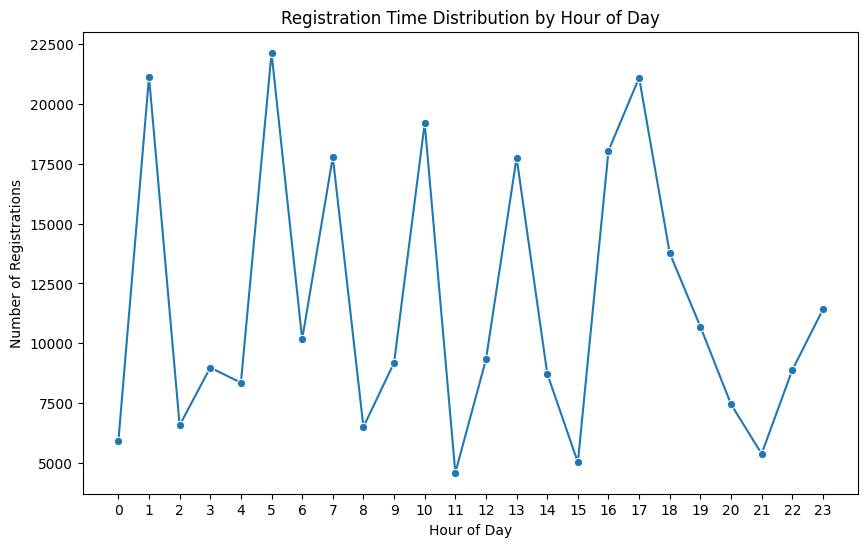

In [13]:
# -------------------------------------------
# Registration Time Distribution
# -------------------------------------------

registration_hours = df_cleaned.withColumn("registration_hour", hour(col("registration_timestamp"))).groupBy("registration_hour").count().orderBy("registration_hour").toPandas()
plt.figure(figsize=(10,6))
sns.lineplot(x='registration_hour', y='count', data=registration_hours, marker='o')
plt.title('Registration Time Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Registrations')
plt.xticks(range(0,24))
plt.show()

We can see from the chart above that registration traffic peaks from 4:00 to 6:00 and again from 15:00 to 19:00.

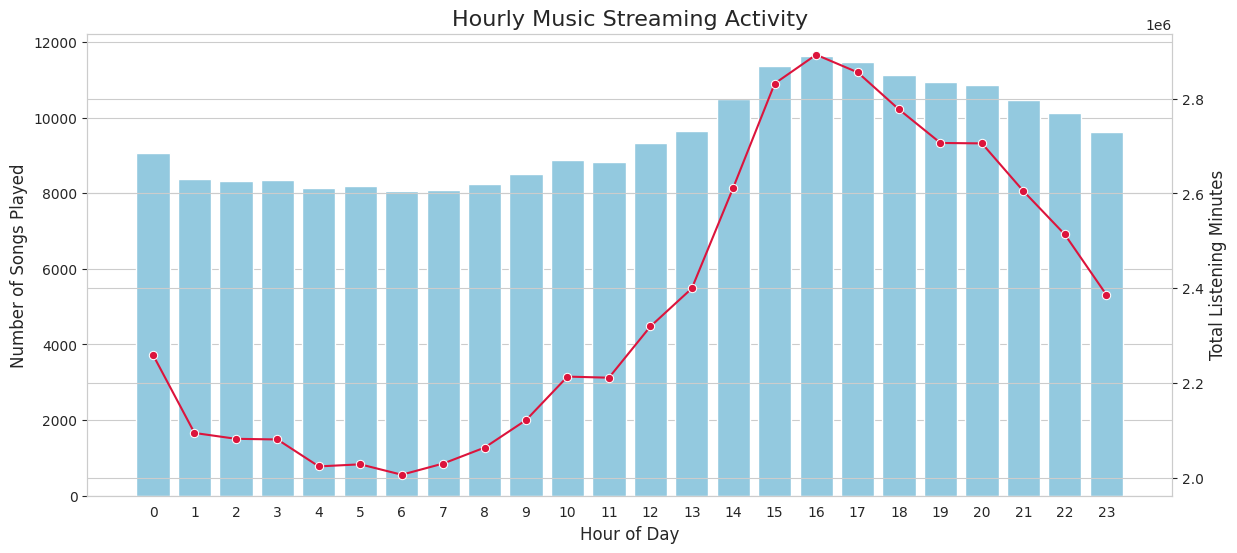

In [14]:
# -------------------------------------------
#  Peak Listening Hours Analysis
# -------------------------------------------

# Convert timestamp and extract hour
df_time = df_cleaned.withColumn("timestamp", from_unixtime(col("ts")/1000)) \
                   .withColumn("hour", hour(col("timestamp")))

# Count song plays per hour
hourly_plays = df_time.filter(col("page") == "NextSong") \
                     .groupBy("hour") \
                     .agg(count("*").alias("play_count"),
                          sum("length").alias("total_duration")) \
                     .orderBy("hour")

# Convert to Pandas for visualization
hourly_pd = hourly_plays.toPandas()

# Create visualization
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Bar plot for play counts
ax1 = sns.barplot(x="hour", y="play_count", data=hourly_pd, color="skyblue")
plt.title("Hourly Music Streaming Activity", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Songs Played", fontsize=12)

# Line plot for duration
ax2 = plt.twinx()
sns.lineplot(x="hour", y="total_duration", data=hourly_pd, 
             color="crimson", marker="o", ax=ax2)
ax2.set_ylabel("Total Listening Minutes", fontsize=12)

plt.show()

As shown, the peak music activity during the day occurs from 14:00 to 19:00. We can take advantage of this high traffic by adding offers and advertising during these hours to engage more users.

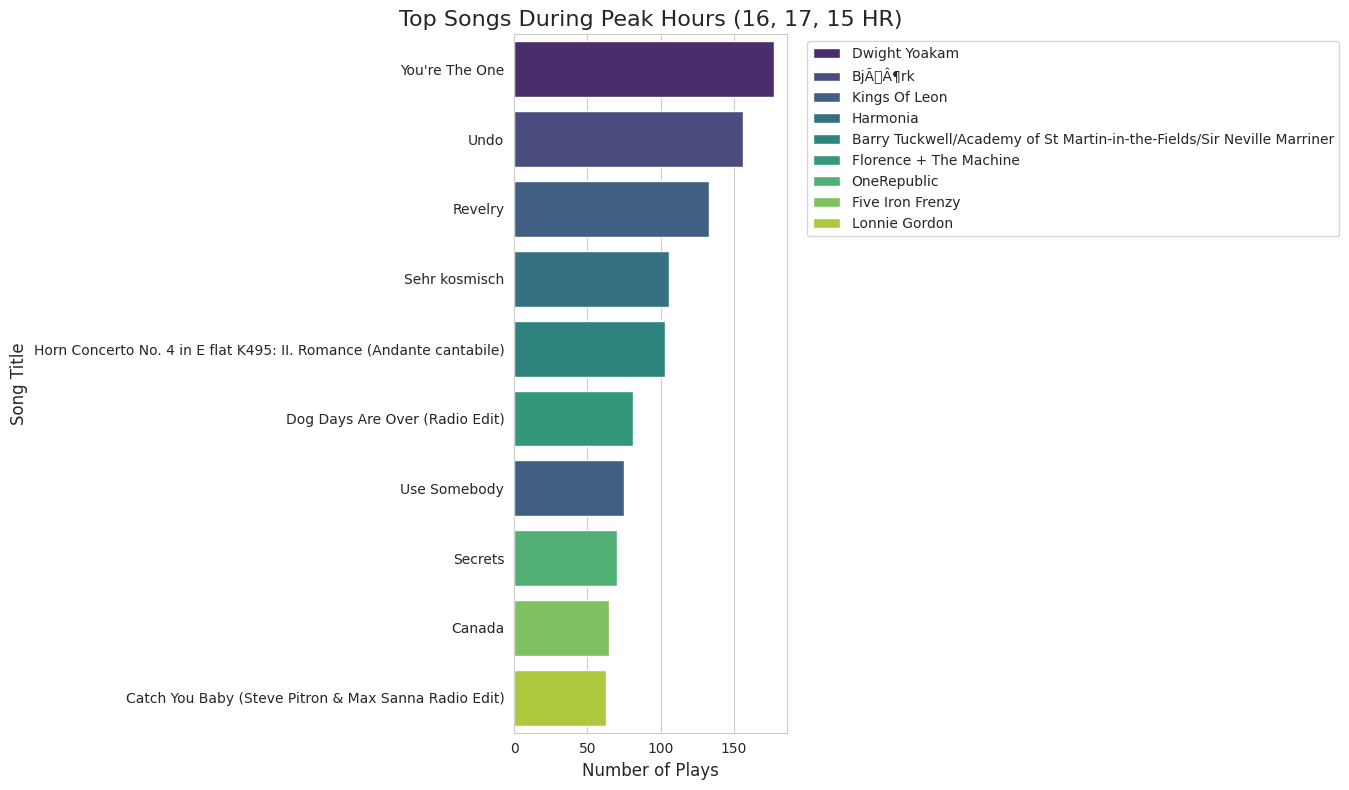

In [15]:
# -------------------------------------------
# Most Popular Songs During Peak Hours
# -------------------------------------------

# Identify peak hours (top 3 hours with most plays)
peak_hours = [row.hour for row in hourly_plays.orderBy(col("play_count").desc()).limit(3).collect()]

# Filter data for peak hours
peak_data = df_time.filter((col("page") == "NextSong") & (col("hour").isin(peak_hours)))

# Analyze top songs during peak hours
top_songs = peak_data.groupBy("song", "artist") \
                    .agg(count("*").alias("play_count"),
                         sum("length").alias("total_duration")) \
                    .orderBy(col("play_count").desc()) \
                    .limit(10)  # Top 10 songs

# Convert to Pandas
top_songs_pd = top_songs.toPandas()

# Create visualization
plt.figure(figsize=(14, 8))
sns.barplot(x="play_count", y="song", hue="artist", 
            data=top_songs_pd, palette="viridis", dodge=False)
plt.title(f"Top Songs During Peak Hours ({', '.join(map(str, peak_hours))} HR)", fontsize=16)
plt.xlabel("Number of Plays", fontsize=12)
plt.ylabel("Song Title", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This chart allows us to determine the most listened-to songs during the peak hours.

In [16]:
# -------------------------------------------
# Detailed Song Analysis Table
# -------------------------------------------

# Create formatted table
display_table = top_songs_pd[["song", "artist", "play_count", "total_duration"]]
display_table["total_duration"] = display_table["total_duration"]/60  # Convert to minutes
display_table.columns = ["Song Title", "Artist", "Play Count", "Total Minutes Listened"]

print(f"\n{' Top Songs During Peak Hours ':-^80}")
display(display_table.style.format({"Total Minutes Listened": "{:.1f}"}) \
                           .background_gradient(cmap="Blues", subset=["Play Count"]))


------------------------- Top Songs During Peak Hours --------------------------


,Song Title,Artist,Play Count,Total Minutes Listened
0,You're The One,Dwight Yoakam,177,706.0
1,Undo,BjÃÂ¶rk,156,906.3
2,Revelry,Kings Of Leon,133,447.3
3,Sehr kosmisch,Harmonia,106,1158.5
4,Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile),Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner,103,475.8
5,Dog Days Are Over (Radio Edit),Florence + The Machine,81,296.5
6,Use Somebody,Kings Of Leon,75,289.4
7,Secrets,OneRepublic,70,262.1
8,Canada,Five Iron Frenzy,65,255.8
9,Catch You Baby (Steve Pitron & Max Sanna Radio Edit),Lonnie Gordon,63,190.3


Through the following table, we can identify the most trending songs and artists, and we can update the music library with newer songs accordingly.

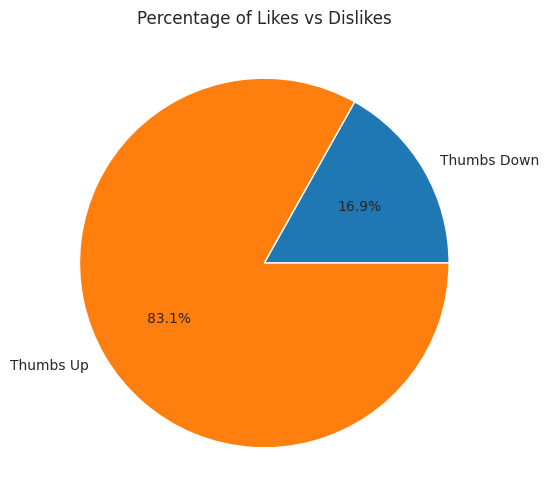

In [17]:
# -------------------------------------------
# Likes/Dislikes Percentage
# -------------------------------------------

feedback_counts = df_cleaned.filter(col("page").isin(["Thumbs Up", "Thumbs Down"])).groupBy("page").count().toPandas()
plt.figure(figsize=(6,6))
plt.pie(feedback_counts['count'], labels=feedback_counts['page'], autopct='%1.1f%%')
plt.title('Percentage of Likes vs Dislikes')
plt.show()

The thumbs-up percentage is looking great so far! But we could add a survey for the thumbs-down responses to help reduce customer churn.

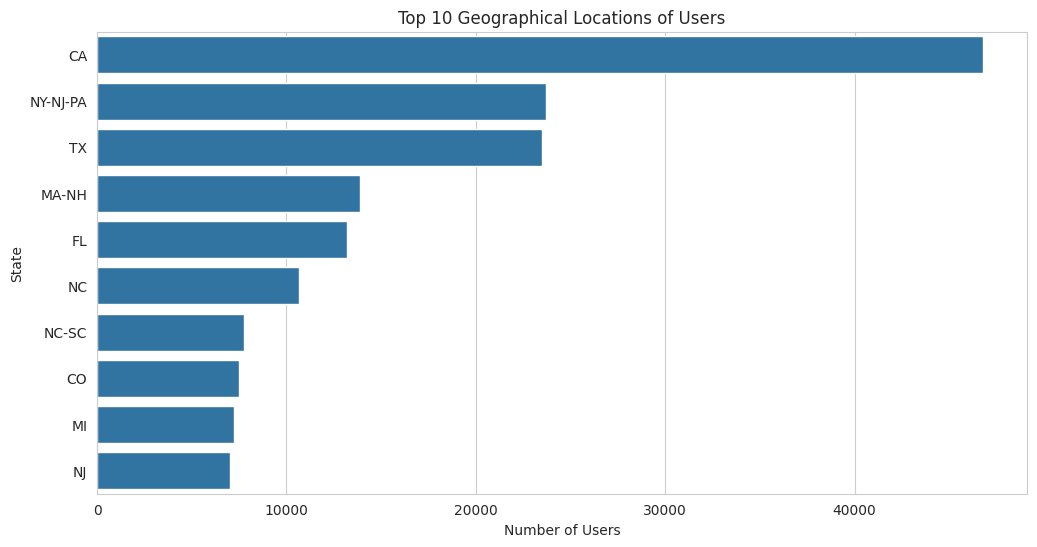

In [18]:
# -------------------------------------------
# Geographical Distribution (Top 10 Locations)
# -------------------------------------------

location_counts = df_cleaned.withColumn("state", split(col("location"), ", ")[1]) \
    .groupBy("state").count() \
    .orderBy(col("count").desc()).limit(10).toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x='count', y='state', data=location_counts, orient='h')
plt.title('Top 10 Geographical Locations of Users')
plt.xlabel('Number of Users')
plt.ylabel('State')
plt.show()

We can see there’s a big difference between states using the app. We could create campaigns and promote the app more in states with fewer users.

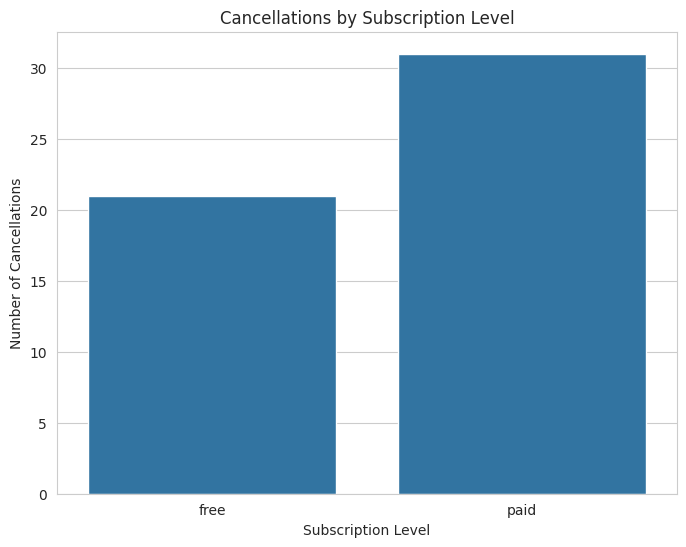

In [19]:
# -------------------------------------------
# Cancellations by Subscription Level
# -------------------------------------------

cancellations = df_cleaned.filter(col("page") == "Cancellation Confirmation").groupBy("level").count().toPandas()
plt.figure(figsize=(8,6))
sns.barplot(x='level', y='count', data=cancellations)
plt.title('Cancellations by Subscription Level')
plt.xlabel('Subscription Level')
plt.ylabel('Number of Cancellations')
plt.show()

There’s a clear difference between paid and free customers, with more cancellations coming from free users. We need a retention plan for these customers to reduce churn.

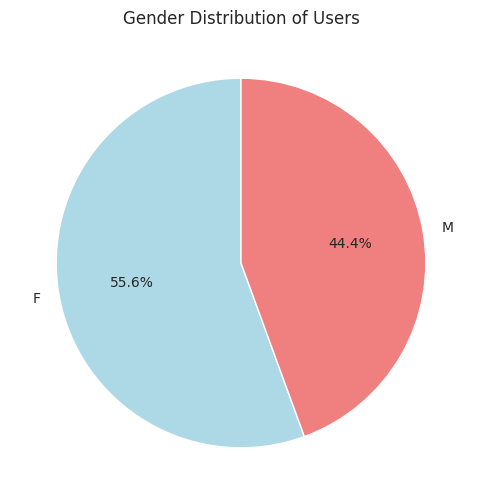

In [20]:
# -------------------------------------------
# Gender Distribution of Users
# -------------------------------------------


# Group by gender and count unique user IDs
gender_counts = df_cleaned.groupBy("gender").agg(count("userId").alias("user_count"))

# Convert the gender_counts DataFrame to a Pandas DataFrame for visualization
gender_counts_pd = gender_counts.toPandas()

# Extract the gender and user_count columns
genders = gender_counts_pd["gender"]
user_counts = gender_counts_pd["user_count"]

# Create a pie chart
plt.figure(figsize=(6, 6))  # Set the size of the chart
plt.pie(user_counts, labels=genders, autopct="%1.1f%%", startangle=90, colors=["lightblue", "lightcoral"])

# Add a title
plt.title("Gender Distribution of Users")

# Display the chart
plt.show()

The data shows there are more female users than male. We could add more promotions to attract male customers.

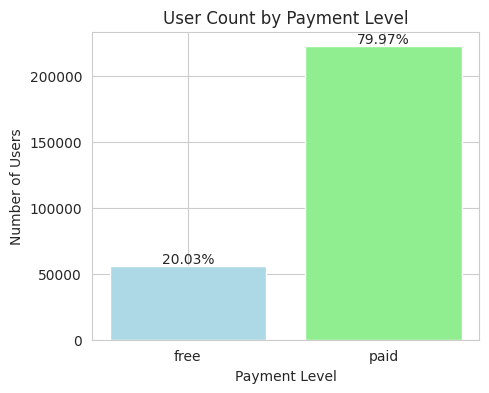

In [21]:
# -------------------------------------------
# User Count by Payment Level
# -------------------------------------------

# Group by "level" and count unique user IDs
payment_status = df_cleaned.groupBy("level").agg(count("userId").alias("user_count"))

# Convert the payment_status DataFrame to a Pandas DataFrame for visualization
payment_status_pd = payment_status.toPandas()

# Extract the level and user_count columns
levels = payment_status_pd["level"]
user_counts = payment_status_pd["user_count"]

# Calculate total user count to get percentages
total_users = user_counts.sum()
percentages = (user_counts / total_users) * 100

# Create a bar chart
plt.figure(figsize=(5, 4))  # Set the size of the chart
bars = plt.bar(levels, user_counts, color=["lightblue", "lightgreen"])

# Add labels and title
plt.xlabel("Payment Level")
plt.ylabel("Number of Users")
plt.title("User Count by Payment Level")

# Add percentages on top of each bar
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()

The chart shows the ratio of subscribers who have access for free versus those who have access through payment.

**We will focus more in our analysis on churned customers, defined as users who have submitted a 'Cancellation Confirmation'.** 

In [22]:
# Add a new column based on the "page" column
df_cleaned = df_cleaned.withColumn(
    "user_status",
    when(col("page") == "Cancellation Confirmation", "Cancelled")
    .otherwise("Active")
)

# Show the updated DataFrame
df_cleaned.select("page", "user_status").distinct().show()

+--------------------+-----------+
|                page|user_status|
+--------------------+-----------+
|     Add to Playlist|     Active|
|Cancellation Conf...|  Cancelled|
|                Help|     Active|
|         Thumbs Down|     Active|
|         Roll Advert|     Active|
|          Add Friend|     Active|
|             Upgrade|     Active|
|           Thumbs Up|     Active|
|      Submit Upgrade|     Active|
|    Submit Downgrade|     Active|
|               About|     Active|
|           Downgrade|     Active|
|              Cancel|     Active|
|       Save Settings|     Active|
|                Home|     Active|
|            NextSong|     Active|
|               Error|     Active|
|            Settings|     Active|
|              Logout|     Active|
+--------------------+-----------+



In [23]:
# Group by "user_status" and count unique user IDs
user_status_counts = df_cleaned.groupBy("user_status").agg(count("userId").alias("user_count"))

# Show the result
user_status_counts.show()

+-----------+----------+
|user_status|user_count|
+-----------+----------+
|  Cancelled|        52|
|     Active|    278102|
+-----------+----------+



**Further exploration of the data will focus on churn, analyzing the factors and patterns related to users who have canceled their subscriptions.**

In [24]:
# Group by user_status and payment_status, and count unique user IDs
user_status_payment_counts = df_cleaned.groupBy("user_status", "level").agg(count("userId").alias("user_count"))

In [25]:
# Show the result
user_status_payment_counts.show()

+-----------+-----+----------+
|user_status|level|user_count|
+-----------+-----+----------+
|  Cancelled| free|        21|
|     Active| paid|    222402|
|     Active| free|     55700|
|  Cancelled| paid|        31|
+-----------+-----+----------+



In [26]:
# Filter for Cancelled users
cancelled_counts = user_status_payment_counts.filter(col("user_status") == "Cancelled")

# Show the result
cancelled_counts.show()

+-----------+-----+----------+
|user_status|level|user_count|
+-----------+-----+----------+
|  Cancelled| free|        21|
|  Cancelled| paid|        31|
+-----------+-----+----------+



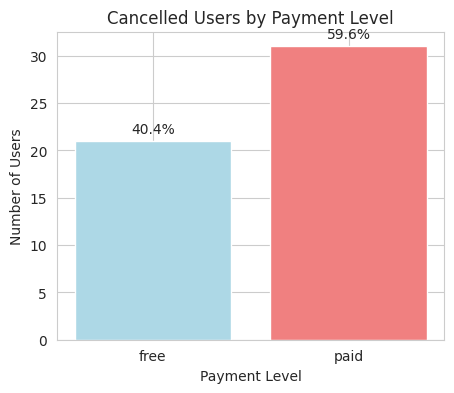

In [27]:
# -------------------------------------------
# Cancelled Users by Payment Level
# -------------------------------------------



# Convert to Pandas DataFrame
cancelled_counts_pd = cancelled_counts.toPandas()

# Calculate the total number of cancelled users
total_users = cancelled_counts_pd["user_count"].sum()

# Calculate the percentage for each level
cancelled_counts_pd["percentage"] = (cancelled_counts_pd["user_count"] / total_users) * 100

# Create a bar chart
plt.figure(figsize=(5, 4))  # Set the size of the chart
bars = plt.bar(cancelled_counts_pd["level"], cancelled_counts_pd["user_count"], color=["lightblue", "lightcoral"])

# Add percentage labels on the bars
for bar, percentage in zip(bars, cancelled_counts_pd["percentage"]):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{percentage:.1f}%', ha='center', va='bottom')

# Add labels and title
plt.xlabel("Payment Level")
plt.ylabel("Number of Users")
plt.title("Cancelled Users by Payment Level")

# Display the chart
plt.show()


The chart shows that the percentage of churned customers is higher for paid customers compared to free customers.

## 4- Feature Engineering

In [28]:
#To get the maximum duration per userid
Max_Duration=df_cleaned.groupBy("userId").agg({"registration_ts_diff_days" : "max"})

In [29]:
#to get the average length per userid
Average_Length=df_cleaned.groupBy("userId").agg({"length" : "avg"})

In [30]:
#select the features that will impact our predicitions
features=df_cleaned.groupBy(["userId","gender"]).pivot("page").agg(functions.count("*"))
features_filtered=features.select( 'userId',"gender",'Help','Downgrade', 'Error', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down',
 'Thumbs Up','Cancellation Confirmation').fillna(0)
Features_Filtered=features_filtered.withColumnRenamed("Cancellation Confirmation","Churn")
gender_transform=StringIndexer(inputCol="gender",outputCol="gender_encoded")
Features_Filtered=gender_transform.fit(Features_Filtered).transform(Features_Filtered)
Features_Filtered=Features_Filtered.drop("gender")

In [31]:
#subscription per userid
Level=df_cleaned.groupBy("userId").pivot("level").agg(functions.countDistinct("userId")).fillna(0)

In [32]:
#Browser Encoding
df_cleaned=df_cleaned.withColumn(
    "Browser",
     when(col("userAgent").contains("Firefox"), "Firefox")
    .when(col("userAgent").contains("Chrome"), "Chrome")
    .when(col("userAgent").contains("Safari"), "Safari")
    .when(col("userAgent").contains("Edge"), "Edge")
    .when(col("userAgent").contains("MSIE"), "Internet Explorer")
    .when(col("userAgent").contains("Trident"), "Internet Explorer")
    .otherwise("Other")  # Default for unrecognized user agents
)
Browser=df_cleaned.groupBy("userId").pivot("Browser").agg(functions.countDistinct("Browser")).fillna(0)

In [33]:
#Operating System Encoding
df_cleaned=df_cleaned.withColumn(
    "Operating System",
     when(col("userAgent").contains("Windows"), "Windows")
    .when(col("userAgent").contains("Mac"), "Mac")
    .when(col("userAgent").contains("Linux"), "Linux")
    .when(col("userAgent").contains("X11"), "Linux")
    .when(col("userAgent").contains("iPhone"), "iPhone")
    .when(col("userAgent").contains("iPad"), "iPad")
    .otherwise("Other")  # Default for unrecognized user agents
)
Operating_System=df_cleaned.groupBy("userId").pivot("Operating System").agg(functions.countDistinct("Operating System")).fillna(0)

In [34]:
#Number of Sessions per User ID
Total_Sessions=df_cleaned.groupBy("userId").agg(functions.countDistinct("sessionId"))

In [35]:
#Number of Songs per User ID
Total_Songs=df_cleaned.groupBy("userId").agg({"song":"count"})

In [36]:
#Join all Dataframes together
df_final = Features_Filtered.join(Level, "userId", "inner") \
              .join(Max_Duration, "userId", "inner") \
              .join(Average_Length, "userId", "inner") \
              .join(Total_Sessions, "userId", "inner")\
              .join(Total_Songs, "userId", "inner")\
              .join(Operating_System, "userId", "inner")\
              .join(Browser, "userId", "inner")
df_final.show(5)

+------+----+---------+-----+----------------+--------------+-----------+---------+-----+--------------+----+----+------------------------------+------------------+-------------------------+-----------+-----+---+-------+------+-------+-----------------+------+
|userId|Help|Downgrade|Error|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Churn|gender_encoded|free|paid|max(registration_ts_diff_days)|       avg(length)|count(DISTINCT sessionId)|count(song)|Linux|Mac|Windows|Chrome|Firefox|Internet Explorer|Safari|
+------+----+---------+-----+----------------+--------------+-----------+---------+-----+--------------+----+----+------------------------------+------------------+-------------------------+-----------+-----+---+-------+------+-------+-----------------+------+
|    44|   6|        1|    0|               0|             1|          2|       25|    0|           1.0|   1|   1|                            37|247.93726979020968|                        3|        429|    0|  1|     

## 5- Machine learning model development and evaluation

**Modeling**
- Split the dataset into train, test, and validation sets. Test out several of the machine learning methods
- Evaluate the accuracy of the various models, tuning parameters as necessary.
- Determine winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I will be using F1 score as the metric to optimize.

In [37]:
assembler=VectorAssembler(inputCols= ['Help',
 'Downgrade',
 'Error',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'gender_encoded',
 'free',
 'paid',
 'max(registration_ts_diff_days)',
 'avg(length)',
 'count(DISTINCT sessionId)',
 'count(song)',
 'Linux',
 'Mac',
 'Windows',
 'Chrome',
 'Firefox',
 'Internet Explorer',
 'Safari'],outputCol="Independet Features")

In [38]:
df_final=assembler.transform(df_final)

In [39]:
model_df = df_final.select(col("churn").alias("Churn"), col("Independet Features"))

In [40]:
#Train Test split
train, validation, test = model_df.randomSplit([0.7, 0.15, 0.15], seed=42)

In [41]:
#Defining the models
gb = GBTClassifier(featuresCol = 'Independet Features', labelCol = 'Churn', seed=0, maxIter=50)
rf = RandomForestClassifier(featuresCol = 'Independet Features', labelCol = 'Churn', seed=0, numTrees=100)
dt = DecisionTreeClassifier(featuresCol = 'Independet Features', labelCol = 'Churn', seed=0)

In [42]:
# Gradient Bosst
gb_model = gb.fit(train)
gb_v_predictions = gb_model.transform(validation)

gb_evaluator = MulticlassClassificationEvaluator(
    labelCol="Churn", 
    predictionCol="prediction", 
    metricName="f1"
)

gb_f1_score = gb_evaluator.evaluate(gb_v_predictions)
print("gb Model F1_Score is {}".format(gb_f1_score))

gb Model F1_Score is 0.6994114857891948


25/02/22 20:38:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/02/22 20:38:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [43]:
#Random Forest
rf_model = rf.fit(train)
rf_v_predictions = rf_model.transform(validation)

rf_evaluator = MulticlassClassificationEvaluator(
    labelCol="Churn", 
    predictionCol="prediction", 
    metricName="f1"
)

rf_f1_score = rf_evaluator.evaluate(rf_v_predictions)
print("rf Model F1_Score is {}".format(rf_f1_score))

25/02/22 20:38:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


rf Model F1_Score is 0.8583968583968583


In [44]:
#Decision Tree
dt_model = dt.fit(train)
dt_v_predictions =dt_model.transform(validation)

dt_evaluator = MulticlassClassificationEvaluator(
    labelCol="Churn", 
    predictionCol="prediction", 
    metricName="f1"
)

dt_f1_score = dt_evaluator.evaluate(dt_v_predictions)
print("df Model F1_Score is {}".format(dt_f1_score))

df Model F1_Score is 0.7245817245817245


In [45]:
#Best Model
# Perform Gridsearch
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100])  # Number of trees
paramGrid = paramGrid.addGrid(rf.maxDepth, [5, 10, 15])  # Maximum depth of trees
paramGrid = paramGrid.build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=rf_evaluator,
                          numFolds=3)

In [46]:
cv_model = crossval.fit(train)
best_rf_model = cv_model.bestModel
rf_predictions = best_rf_model.transform(validation)

rf_f1_score = rf_evaluator.evaluate(rf_predictions)
print(f"Best RF Model F1-Score: {rf_f1_score}")

Best RF Model F1-Score: 0.8179088179088179


In [47]:
# Use the best model to make predictions on the test set
test_predictions = rf_model.transform(test)

# Evaluate the final model performance on the test set
test_f1_score = rf_evaluator.evaluate(test_predictions)

print(f"Random Forest Final Test Set F1-Score: {np.round(test_f1_score*100, 2)}%")

Random Forest Final Test Set F1-Score: 79.39%


In [48]:
# Print confusion matrix
# Select only prediction and label columns
predictionAndLabels = test_predictions.select(col("prediction").cast("double"), 
                        col("Churn").cast("double")).na.fill(0, subset=["Churn"])

predictionAndLabels.printSchema()

root
 |-- prediction: double (nullable = false)
 |-- Churn: double (nullable = false)



In [49]:
rdd=predictionAndLabels.select("prediction","churn").rdd.map(tuple)
metrics = MulticlassMetrics(rdd)

In [50]:
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)

Confusion Matrix:
 [[20.  0.]
 [ 4.  1.]]


In [51]:
# Extract feature importances
importances = rf_model.featureImportances.toArray()

# Convert to a Pandas DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature_Index": range(len(importances)),
    "Importance": importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

In [52]:
feature_importance_df

,Feature_Index,Importance
10,10,0.258139
11,11,0.105089
5,5,0.095853
6,6,0.087708
12,12,0.079350
13,13,0.067588
0,0,0.058809
1,1,0.051096
2,2,0.035206
18,18,0.021775


In [53]:
# Map feature importance to feature names

feature_cols  = ['Help',
 'Downgrade',
 'Error',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'gender_encoded',
 'free',
 'paid',
 'max(registration_ts_diff_days)',
 'avg(length)',
 'count(DISTINCT sessionId)',
 'count(song)',
 'Linux',
 'Mac',
 'Windows',
 'Chrome',
 'Firefox',
 'Internet Explorer',
 'Safari']

feature_importance_df["Feature_Name"] = feature_importance_df["Feature_Index"].apply(lambda i: feature_cols[i])

feature_importance_df

,Feature_Index,Importance,Feature_Name
10,10,0.258139,max(registration_ts_diff_days)
11,11,0.105089,avg(length)
5,5,0.095853,Thumbs Down
6,6,0.087708,Thumbs Up
12,12,0.079350,count(DISTINCT sessionId)
13,13,0.067588,count(song)
0,0,0.058809,Help
1,1,0.051096,Downgrade
2,2,0.035206,Error
18,18,0.021775,Firefox


**Recommendations:**
1. Early Warning System: Implement alerts for users showing >3 Thumbs Down/week
2. Retention Campaigns: Focus on users identified in our analysis who gave a thumbs down, including both paid and non-paid customers.
